In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

from helper import *

In [2]:
# import wandb
# from wandb.keras import WandbCallback

## Data Download

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


## Data SPlitting

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2


train_dataset, val_dataset = splits(
    ds_train, TRAIN_RATIO, VAL_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [6]:
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()))

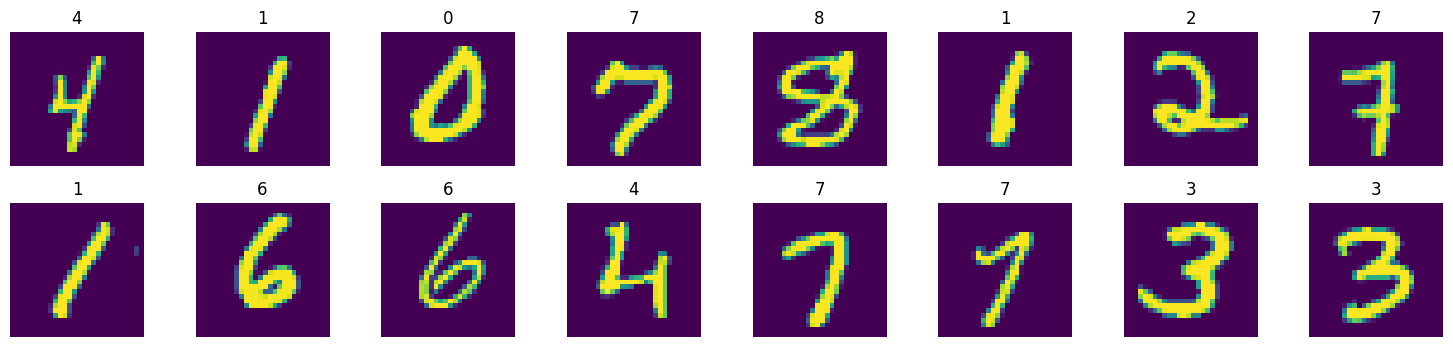

In [7]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label.numpy()))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 24,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}


### Data Generator

In [9]:
def resize_rescale(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [10]:
train_ = train_dataset.map(resize_rescale)
train_data = train_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

val_ = val_dataset.map(resize_rescale)
validation_data = val_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

test_ = ds_test.map(resize_rescale)
# test_data = test_.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience = 20,
    verbose=1,
    mode = 'auto',
    baseline= None,
    restore_best_weights = True
)

In [12]:
test_data = test_.batch(1)

## Model Training

### Model Generation

In [13]:
func_input = Input(shape=(28, 28, 1), name="Input Image")


x =    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu')(func_input)
x =    tf.keras.layers.BatchNormalization()(x)
x =   tf.keras.layers.MaxPooling2D(pool_size=(
        2, 2), strides=(2, 2), padding='valid')(x)

x =   tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu')(x)
x =   tf.keras.layers.BatchNormalization()(x)
x =   tf.keras.layers.MaxPooling2D(pool_size=(
        2, 2), strides=(2, 2), padding='valid')(x)

x =    tf.keras.layers.Flatten()(x)

x =    tf.keras.layers.Dense(120, activation='relu')(x)
x =    tf.keras.layers.BatchNormalization()(x)
x =    tf.keras.layers.Dense(84, activation='relu')(x)
x =    tf.keras.layers.BatchNormalization()(x)
func_output = tf.keras.layers.Dense(10, activation='softmax')(x)


lenet_model_func = Model(func_input, func_output, name="Lenet_Model_Func")

lenet_model_func.summary()

Model: "Lenet_Model_Func"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 16)     

In [14]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
        self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2+4, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
    def call(self,x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)
        
        return x
    

class ModelExtractor(Model):
    def __init__(self):
        super(ModelExtractor, self).__init__()

        self.fetaure_extractor = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)
        
        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training):
        x = self.fetaure_extractor(x)
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x
    
feature_sub_classed = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

model_sub_classed = ModelExtractor()

In [15]:
func_input = Input(shape=(28, 28, 1), name="Input Image")

func_output = model_sub_classed(func_input)

lenet_model_sub_classed = Model(func_input, func_output, name="Lenet_Model_sub_classed")

lenet_model_sub_classed.summary()

Model: "Lenet_Model_sub_classed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 model_extractor (ModelExtr  (None, 10)                45330     
 actor)                                                          
                                                                 
Total params: 45330 (177.07 KB)
Trainable params: 44878 (175.30 KB)
Non-trainable params: 452 (1.77 KB)
_________________________________________________________________


### Callbacks

In [16]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_sparse_categorical_accuracy')>=0.992):
            print("99.5% Accuracy is reached .......Hence Stopping")
            self.model.stop_training=True  
                                                                                   
def schedule_func(epoch,lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Giving call back for accuracy
callbacks = CustomCallback() 

# Giving call back for EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
      
# Logging the losses and metrics data
filename = 'log.csv'
csv_logger = tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)

# Changing Learning Rate with a Scheduler function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_func)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
                                                    factor=0.1,
                                                    patience=3,
                                                    verbose=1,
                                                    mode='auto'                                      
                                                )

# Saving the best model and its weights to given path
checkpoint_filepath = 'weights/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                    filepath=checkpoint_filepath,
                                                                    verbose = 1,
                                                                    save_weights_only=True,
                                                                    save_best_only=True,
                                                                    monitor='val_loss',
                                                                    mode='auto'
                                                                    )

### Training

In [17]:
lenet_model_sub_classed.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics=['sparse_categorical_accuracy'])

lenet_history = lenet_model_sub_classed.fit(train_data,
                            validation_data=validation_data,
                            epochs=50,
                            verbose=2,
                            callbacks = [callbacks, 
                                         early_stopping, 
                                         csv_logger, 
                                         lr_scheduler, 
                                         model_checkpoint_callback])

Epoch 1/50




Epoch 1: val_loss improved from inf to 0.08413, saving model to weights/tmp\checkpoint
375/375 - 10s - loss: 0.1414 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.0841 - val_sparse_categorical_accuracy: 0.9742 - lr: 0.0100 - 10s/epoch - 27ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.08413
375/375 - 7s - loss: 0.0603 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9721 - lr: 0.0100 - 7s/epoch - 18ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.08413
375/375 - 7s - loss: 0.0437 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.0949 - val_sparse_categorical_accuracy: 0.9729 - lr: 0.0100 - 7s/epoch - 18ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.08413 to 0.05148, saving model to weights/tmp\checkpoint
375/375 - 7s - loss: 0.0357 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9861 - lr: 0.0100 - 7s/epoch - 19ms/step
Epoch 5/50

Epoch 5: val_loss improve

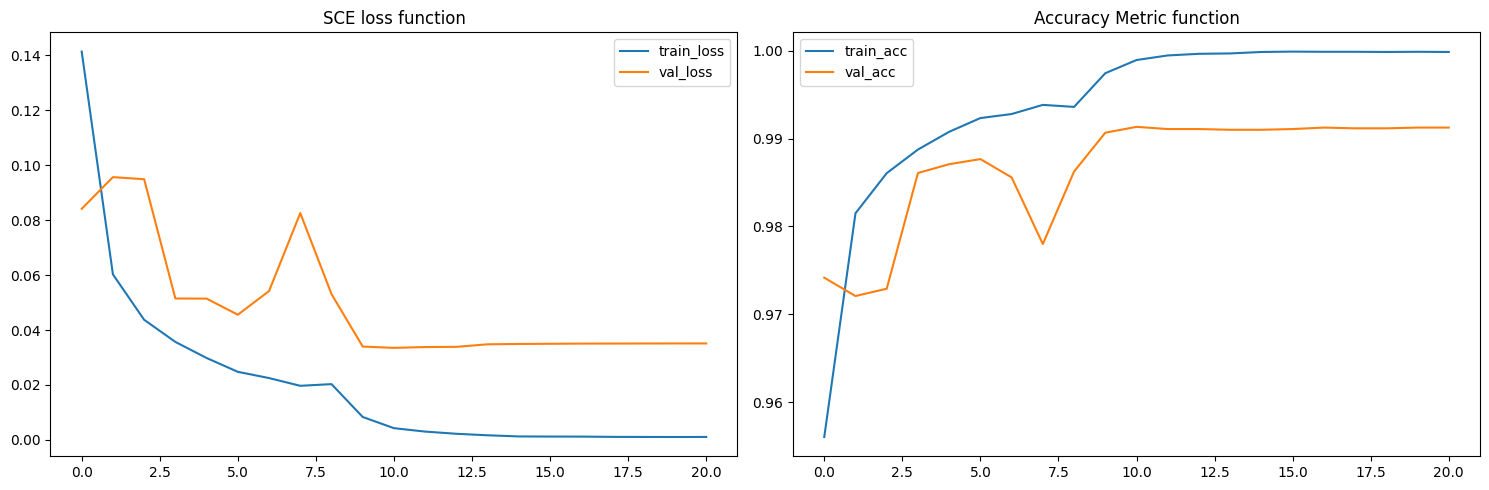

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(lenet_history.history['loss'], label="train_loss")
ax[0].plot(lenet_history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(lenet_history.history['sparse_categorical_accuracy'], label="train_acc")
ax[1].plot(lenet_history.history['val_sparse_categorical_accuracy'],
           label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

### Model Evaluation

In [19]:
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 28s 3ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9922


[0.029268691316246986, 0.9922000169754028]

1/1 [==============================] - 0s 25ms/step


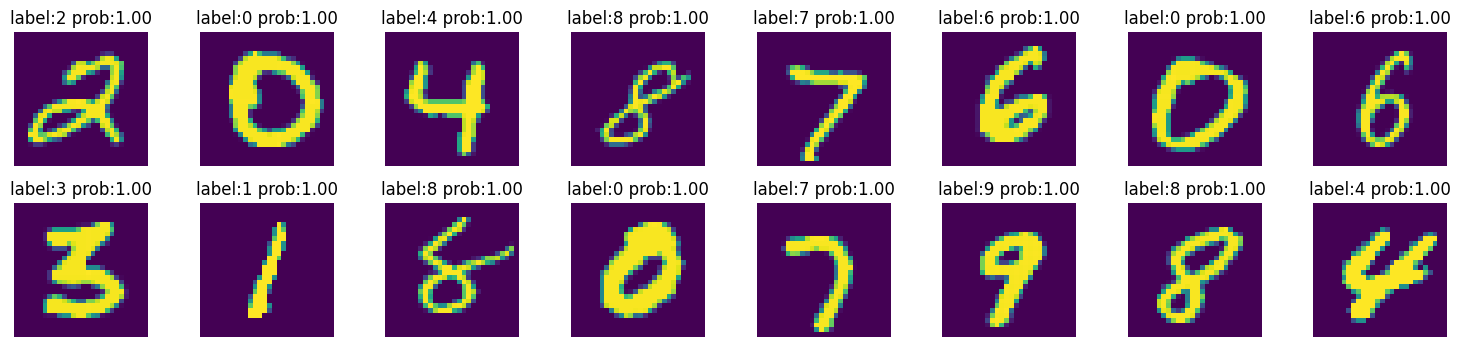

1/1 [==============================] - 0s 48ms/step


array([[4.6146059e-11, 1.6725983e-10, 1.0000000e+00, 1.2283795e-08,
        3.1573519e-09, 1.3472530e-10, 7.0275945e-11, 1.4997614e-11,
        3.7191066e-09, 5.5247935e-11]], dtype=float32)

In [25]:
plt.figure(figsize=(15, 7))


for i, (image, label) in enumerate(test_data.take(16)):

  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(tf.squeeze(image, axis=0))

  pred_prob_lst = lenet_model_sub_classed.predict(image)

  pred_label = np.argmax(pred_prob_lst)

  pred_prob = np.max(pred_prob_lst)

  plt.title(f"label:{pred_label} prob:{pred_prob:.2f}")

  plt.axis('off')
plt.tight_layout()


plt.show()

lenet_model_sub_classed.predict(test_data.take(1))

## Saving Model

In [43]:
lenet_model_sub_classed.save_weights('weights/lenet_weights')
lenet_model_sub_classed.load_weights('weights/lenet_weights')
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 31s 3ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9922


[0.029268691316246986, 0.9922000169754028]

In [44]:
lenet_model_sub_classed.load_weights(checkpoint_filepath)
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 29s 3ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9922


[0.029268691316246986, 0.9922000169754028]